<h1 style="text-align: center"> Assignment 3: Helping Customer Support team to reach out to customers with abnormal behaviors from their usual spending patterns </h1>

### Savinay Singh 
### Student ID: <b><u>24591935</u></b>
### 26 May 2023


<p style="font-size:18px;">Table of Content
<ol>  
    <li>Importing the libraries</li>
    <li>Importing the datasets</li>
    <li>Check for missing values</li>
    <li>Merging the datasets</li>
    <li>Dataset Preparation</li>
    <li>Data Visualisations</li>
    <li>Label Encoding</li>
    <li>Feature Scaling</li>
    <li>Anomaly Detection Model</li>
    <li>Model Evaluation</li>
    <li>Feature Importance</li>

</ol>
</p>

# 1. Importing the libraries

<p style="font-size:18px;">
    To utilise the pre-written code and functionality the libraries given below are imported. 
</p>

In [1]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from datetime import datetime
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
import numpy as np

# 2. Importing the datasets

In [2]:
csv_files = glob.glob("./transactions/*.csv")
df_transactions=pd.DataFrame()
for file in csv_files:
    df_transactions=pd.concat([df_transactions, pd.read_csv(file,sep='|')], ignore_index=True)

<pre style="font-size:18px;">
<u>Dataset Column dictionary for df_transactions</u>
cc_num: Credit card number associated with the transaction.
acct_num: Account number associated with the transaction.
trans_num: Unique identifier for the transaction.
unix_time: Unix timestamp indicating the time of the transaction.
category: Category or type of transaction (e.g., gas_transport).
amt: Amount of the transaction.
is_fraud: Binary flag indicating whether the transaction is classified as fraud (1) or not (0).
merchant: Name of the merchant involved in the transaction.
merch_lat: Latitude coordinate of the merchant's location.
merch_long: Longitude coordinate of the merchant's location.
</pre>

In [3]:
df_transactions.head(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,4896331812335761701,149852234418,f3ec0819590302134f03ffdc2f44697f,1646060228,gas_transport,65.17,0,"Larson, Ryan and Huang",38.143430,-90.327335
1,4896331812335761701,149852234418,c1607c993e41f2c3b42d72d1506bef7b,1644848624,gas_transport,47.58,0,Myers-Reed,39.119498,-90.760379
2,4896331812335761701,149852234418,6f530db25d20fe351249a54491fd3fde,1645632153,gas_transport,64.43,0,Baker-Bullock,39.384368,-90.361517
3,4896331812335761701,149852234418,6d11805f2acd938fec99376001afafe8,1645311286,gas_transport,82.47,0,Spencer-Hall,39.443567,-89.752400
4,4896331812335761701,149852234418,605342f297c575cb1ccf2c08cad082ee,1641571926,gas_transport,50.28,0,"King, Rodriguez and Hancock",38.857278,-89.609525


In [4]:
df_customers=pd.read_csv('./customer/customers.csv',sep='|')

<pre style="font-size:18px;">
<u>Dataset Column dictionary for df_customers</u>
ssn: Social Security Number of the individual.
cc_num: Credit card number associated with the individual.
first: First name of the individual.
last: Last name of the individual.
gender: Gender of the individual.
street: Street address of the individual.
city: City of residence of the individual.
state: State of residence of the individual.
zip: ZIP code of the individual's address.
lat: Latitude coordinate of the individual's address.
long: Longitude coordinate of the individual's address.
city_pop: Population of the city.
job: Occupation or job title of the individual.
dob: Date of birth of the individual.
acct_num: Account number associated with the individual.
</pre>

In [5]:
df_customers.head(5)

,ssn,cc_num,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,acct_num
0,115-04-4507,4218196001337,Jonathan,Johnson,M,863 Lawrence Valleys,Ambler,PA,19002,40.1809,-75.2156,32412,Accounting technician,1959-10-03,888022315787
1,715-55-5575,4351161559407816183,Elaine,Fuller,F,310 Kendra Common Apt. 164,Leland,NC,28451,34.2680,-78.0578,27112,Professor Emeritus,1963-06-07,917558277935
2,167-48-5821,4192832764832,Michael,Cameron,M,05641 Robin Port,Cordova,SC,29039,33.4275,-80.8857,4215,International aid/development worker,1973-05-30,718172762479
3,406-83-7518,4238849696532874,Brandon,Williams,M,26916 Carlson Mountain,Birmingham,AL,35242,33.3813,-86.7046,493806,Seismic interpreter,1942-12-26,947268892251
4,697-93-1877,4514627048281480,Lisa,Hernandez,F,809 Burns Creek,Fargo,GA,31631,30.7166,-82.5801,559,Medical laboratory scientific officer,1939-05-22,888335239225


# 3. Check for missing values

<p style="font-size:18px;">
    The bar plot below shows that there is no missing values in df_transactions and df_customers dataset
</p>

<BarContainer object of 15 artists>

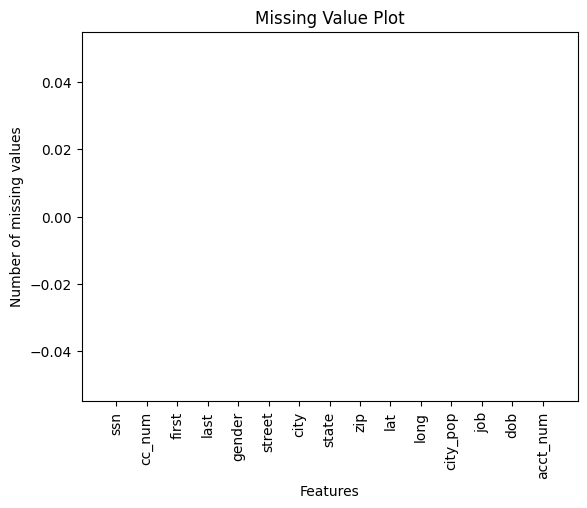

In [6]:
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Number of missing values')
plt.title('Missing Value Plot')
plt.bar(df_customers.isna().sum().index,df_customers.isna().sum().values)

<BarContainer object of 10 artists>

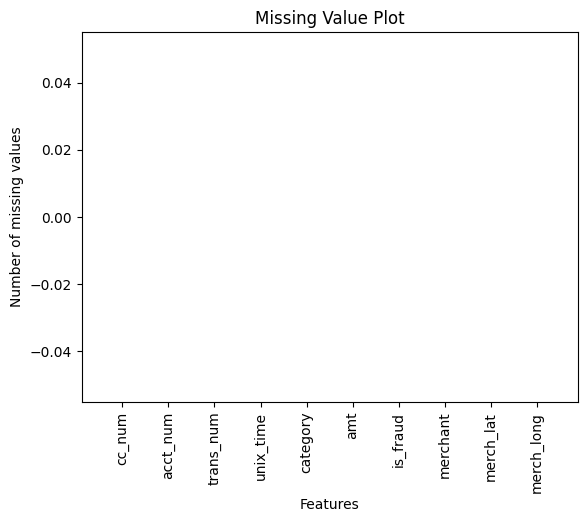

In [7]:
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Number of missing values')
plt.title('Missing Value Plot')
plt.bar(df_transactions.isna().sum().index,df_transactions.isna().sum().values)

# 4. Merging the datasets

<p style="font-size:18px;"> Both cc_num and acct_num can act as primary key to join these datasets. Conceptually, there can be multiple credit cards affiliated to one account and not the other way around. This hypothesis can be verified by checking if the cc_num has a many-to-one relationship with acct_num or not

</p>

In [8]:
# Check for one-to-one relationship
one_to_one = len(df_customers.groupby(['cc_num', 'acct_num'])) == df_customers['cc_num'].nunique() == df_customers[ 'acct_num'].nunique()

if one_to_one:
    print(f"The columns 'cc_num' and 'acct_num' have a one-to-one relationship.")
else:
    print(f"The columns 'cc_num' and 'acct_num' do not have a one-to-one relationship.")

The columns 'cc_num' and 'acct_num' have a one-to-one relationship.


In [9]:
# Check for one-to-one relationship
one_to_one = len(df_transactions.groupby(['cc_num', 'acct_num'])) == df_transactions['cc_num'].nunique() == df_transactions[ 'acct_num'].nunique()

if one_to_one:
    print(f"The columns 'cc_num' and 'acct_num' have a one-to-one relationship.")
else:
    print(f"The columns 'cc_num' and 'acct_num' do not have a one-to-one relationship.")

The columns 'cc_num' and 'acct_num' have a one-to-one relationship.


<p style="font-size:18px;"> As cc_num and acct_num have a one-to-one relationship, they can both be used as a primary key for the left join. In order to align with real-world conventions, the cc_num is selected for this purpose in the actual dataset.
</p>

In [10]:
df_merged=pd.merge(df_transactions,df_customers,on='cc_num',how='left')

In [11]:
df_merged=df_merged.drop('acct_num_y',axis=1)

In [12]:
df_merged=df_merged.rename(columns={'acct_num_x':'acct_num'})

# 5. Dataset Preparation

In [13]:
df_merged.head(5)

,cc_num,acct_num,trans_num,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,...,gender,street,city,state,zip,lat,long,city_pop,job,dob
0,4896331812335761701,149852234418,f3ec0819590302134f03ffdc2f44697f,1646060228,gas_transport,65.17,0,"Larson, Ryan and Huang",38.143430,-90.327335,...,M,4457 Mercado Extensions,Brussels,IL,62013,38.9255,-90.5968,552,Patent attorney,2002-07-27
1,4896331812335761701,149852234418,c1607c993e41f2c3b42d72d1506bef7b,1644848624,gas_transport,47.58,0,Myers-Reed,39.119498,-90.760379,...,M,4457 Mercado Extensions,Brussels,IL,62013,38.9255,-90.5968,552,Patent attorney,2002-07-27
2,4896331812335761701,149852234418,6f530db25d20fe351249a54491fd3fde,1645632153,gas_transport,64.43,0,Baker-Bullock,39.384368,-90.361517,...,M,4457 Mercado Extensions,Brussels,IL,62013,38.9255,-90.5968,552,Patent attorney,2002-07-27
3,4896331812335761701,149852234418,6d11805f2acd938fec99376001afafe8,1645311286,gas_transport,82.47,0,Spencer-Hall,39.443567,-89.752400,...,M,4457 Mercado Extensions,Brussels,IL,62013,38.9255,-90.5968,552,Patent attorney,2002-07-27
4,4896331812335761701,149852234418,605342f297c575cb1ccf2c08cad082ee,1641571926,gas_transport,50.28,0,"King, Rodriguez and Hancock",38.857278,-89.609525,...,M,4457 Mercado Extensions,Brussels,IL,62013,38.9255,-90.5968,552,Patent attorney,2002-07-27


<p style="font-size:18px;">
   Removing sensitive information such as cc_num, acct_num, and trans_num,ssn from the dataset used for anomaly detection in finding abnormal spending patterns is primarily done to ensure data privacy and security. These features contain sensitive and personally identifiable information (PII), such as credit card numbers and account identifiers, which should be handled with caution to protect the privacy of individuals.
</p>

In [14]:
df_merged=df_merged.drop(['cc_num','acct_num','trans_num','ssn'],axis=1)

<p style="font-size:18px;">
   In many real-world scenarios, the is_fraud label is not available during the time of anomaly detection. So, removing it is a good idea
</p>

In [15]:
fraud_label=df_merged['is_fraud']

In [16]:
df_merged=df_merged.drop(['is_fraud'],axis=1)

<p style="font-size:18px;">
    In many cases, first and last names are not directly related to spending behavior. First and last names are personally identifiable information (PII) that can potentially compromise the privacy of individuals. Removing sensitive information like names helps ensure compliance with data protection regulations and maintain the anonymity of the individuals in the dataset.
</p>

In [17]:
df_merged=df_merged.drop(['first','last'],axis=1)

<p style="font-size:18px;">
    Conclusively determining a person's full identity based solely on their age and street address is even more improbable compared to utilizing both date of birth and street name. Therefore, it may be preferable to convert the date of birth to age for better anonymity and privacy protection.
</p>

In [18]:
df_merged.dob=[datetime.strptime(dob_str, "%Y-%m-%d") for dob_str in df_merged.dob]

In [19]:
age=[datetime.today()-dob for dob in df_merged.dob]

In [20]:
age = [divmod(a.days, 365.25)[0] for a in age]

In [21]:
df_merged['Age']=age
df_merged=df_merged.drop('dob',axis=1)

<p style="font-size:18px;">
    Address details such as latitude, longitude are considered personally identifiable information (PII) that can potentially compromise the privacy of both the customers and the merchants. 
</p>

In [22]:
df_merged=df_merged.drop(['merch_lat','merch_long','lat','long'],axis=1)

<p style="font-size:18px;">
    In most cases, combining a person's age and zip code would still not be enough to definitively obtain their full identity. While this combination of information can help narrow down potential matches within a specific area and age range, it is still insufficient to accurately identify a specific individual. Combining a person's age, city, state, and street address could potentially increase the chances of identifying an individual, especially in a more specific geographic area. This combination of information provides more specific details about a person's demographic and location. 
</p>

In [23]:
df_merged=df_merged.drop(['street','city','state'],axis=1)

<p style="font-size:18px;">
Unix time serves as a timestamp for each transaction, enabling the analysis of spending patterns over time. By taking into account the temporal dimension, one can identify anomalies that occur during specific periods or detect abnormal trends in spending behavior. Instances of sudden increases or decreases in spending within particular time intervals may suggest irregular activity. It is important to note, however, that the primary focus of anomaly detection lies in examining spending patterns rather than emphasizing the temporal aspects of the data.
</p>

In [24]:
df_merged=df_merged.drop('unix_time',axis=1)

<p style="font-size:18px;">
Converting age into age group to provide a better understanding of spending behavior across different life stages.
</p>

In [25]:
age_groups = {
    (0, 17): 'Under 18',
    (18, 24): '18-24',
    (25, 34): '25-34',
    (35, 44): '35-44',
    (45, 54): '45-54',
    (55, 64): '55-64',
    (65, 120): '65 and above'
}
# Function to map age to age group
def map_age_group(age):
    for age_range, group_label in age_groups.items():
        if age_range[0] <= age <= age_range[1]:
            return group_label
    return 'Unknown'



In [26]:
# Apply the age group mapping to the 'Age' column
df_merged['Age Group']=df_merged['Age'].apply(map_age_group)
df_merged=df_merged.drop('Age',axis=1)

# 6. Data Visualisation

<p style="font-size:18px;">
   The bar graph presented below illustrates the occurrence of transactions for each category. The data clearly indicates that physical point-of-sale (POS) systems or in-store transactions of grocery shopping account for the highest transactions, followed by home purchases.
</p>

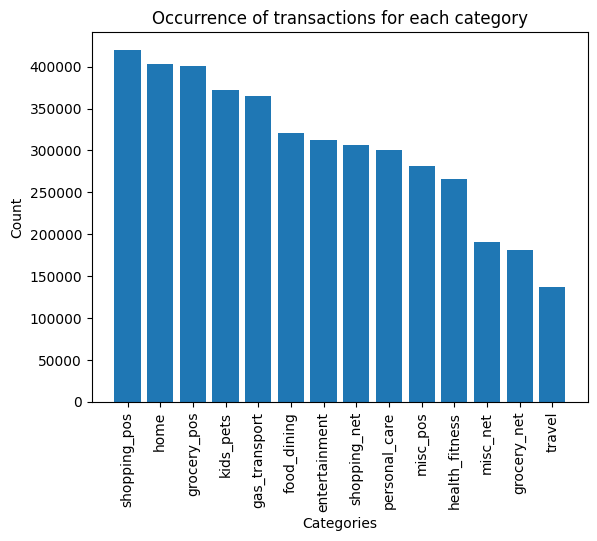

In [27]:
plt.bar(df_merged.category.value_counts().index, df_merged.category.value_counts().values)
# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Occurrence of transactions for each category')
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)
plt.show()

<p style="font-size:18px;">
  The following bar graph showcases the average spending across different categories. The data clearly indicates that online grocery shopping or digital platform purchases account for the highest spending, followed by miscellaneous online purchases.
</p>

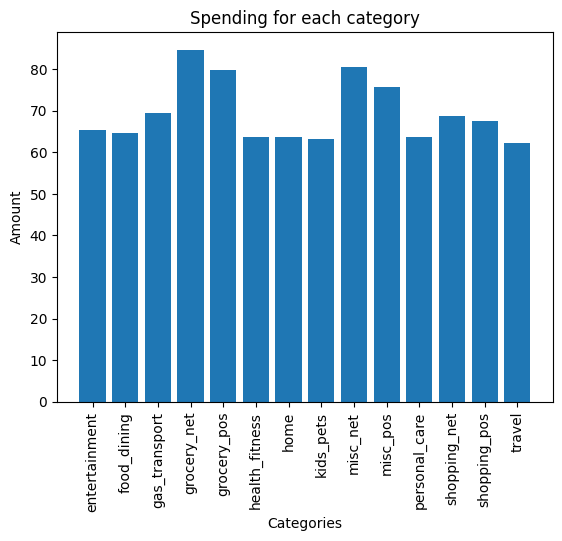

In [28]:
plt.bar(df_merged.groupby(by=['category'])['amt'].mean().reset_index().category, df_merged.groupby(by=['category'])['amt'].mean().reset_index().amt)
# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Amount')
plt.title('Spending for each category')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

<p style="font-size:18px;">
   The pie chart presented below illustrates the occurrence of transactions for each gender. It is evident that females do more number of transactions than  males.
</p>

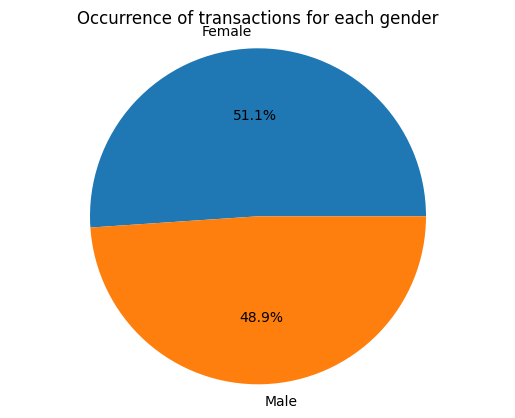

In [29]:
plt.pie(df_merged.gender.value_counts().values, labels=df_merged.gender.value_counts().index.map({'F': 'Female', 'M': 'Male'}), autopct='%1.1f%%')

# Add title
plt.title('Occurrence of transactions for each gender')

# Set aspect ratio to 'equal' for a circular pie
plt.axis('equal')

# Display the plot
plt.show()

<p style="font-size:18px;">
   The pie chart presented below illustrates the spending proportion for each gender. It is evident that females spend more than males.
</p>

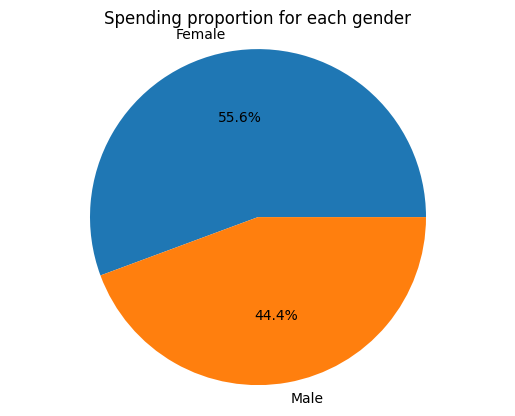

In [30]:
plt.pie(df_merged.groupby(by=['gender'])['amt'].mean().reset_index().amt, labels=df_merged.groupby(by=['gender'])['amt'].mean().reset_index().gender.map({'F': 'Female', 'M': 'Male'}), autopct='%1.1f%%')

# Add title
plt.title('Spending proportion for each gender')

# Set aspect ratio to 'equal' for a circular pie
plt.axis('equal')

# Display the plot
plt.show()

<p style="font-size:18px;">
   The bar graph presented below illustrates the occurrence of transactions for each age group. The data clearly indicates that 25-34 year age group makes highest number of transactions.
</p>

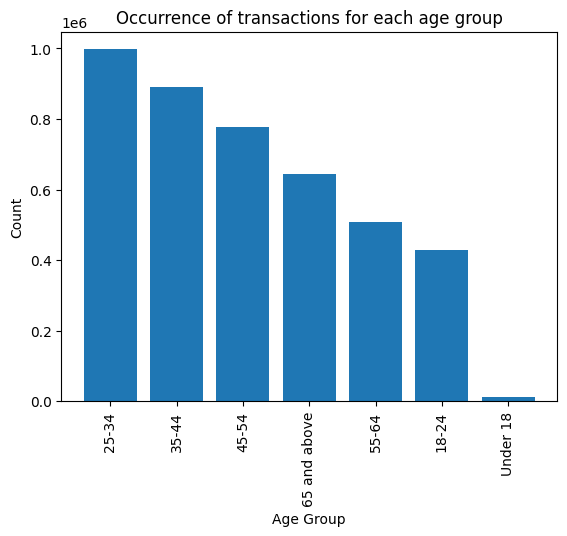

In [31]:
plt.bar(df_merged['Age Group'].value_counts().index, df_merged['Age Group'].value_counts().values)
# Add labels and title
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Occurrence of transactions for each age group')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

<p style="font-size:18px;">
   The bar graph presented below illustrates the average spendings for each age group. The data clearly indicates that 25-34 year age group spends the highest closely followed by 35-44 year age group.
</p>

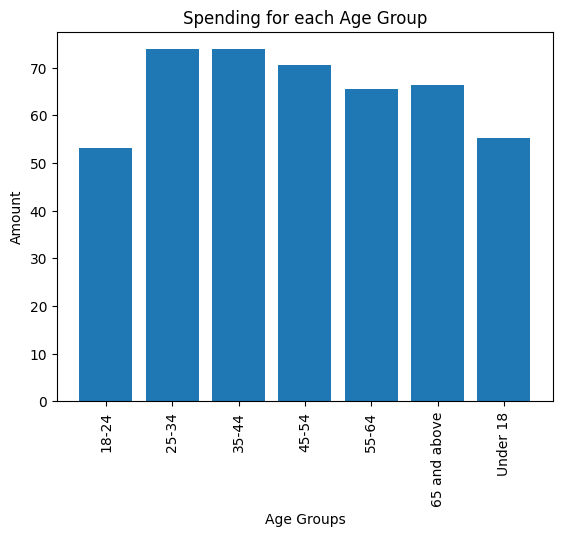

In [32]:
plt.bar(df_merged.groupby(by=['Age Group'])['amt'].mean().reset_index()['Age Group'], df_merged.groupby(by=['Age Group'])['amt'].mean().reset_index().amt)
# Add labels and title
plt.xlabel('Age Groups')
plt.ylabel('Amount')
plt.title('Spending for each Age Group')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

In [33]:
df_merged.groupby(by=['merchant'])['amt'].mean().sort_values(ascending=False)

merchant
Romero, Bell and Williams            389.719844
Vaughn-Hogan                         345.382828
Jenkins, Clark and Anderson          315.547534
Santiago, Carroll and Chen           306.166204
Villanueva, Castillo and Randolph    246.009494
                                        ...    
Thomas, Hart and Ballard              34.086308
Waller PLC                            34.025625
Nguyen-Thomas                         33.261905
Camacho LLC                           33.232800
Hughes-Mckay                          32.770000
Name: amt, Length: 21977, dtype: float64

<p style="font-size:18px;">
   The following bar graph depicts the average spendings for various merchants, highlighting the top 10 highest average spending amounts.
</p>

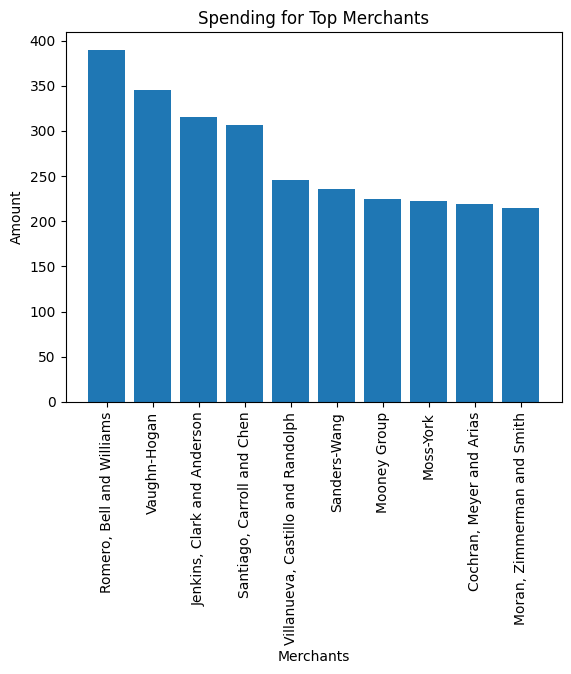

In [34]:
plt.bar(df_merged.groupby(by=['merchant'])['amt'].mean().sort_values(ascending=False)[0:10].index, df_merged.groupby(by=['merchant'])['amt'].mean().sort_values(ascending=False)[0:10].values)
# Add labels and title
plt.xlabel('Merchants')
plt.ylabel('Amount')
plt.title('Spending for Top Merchants')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

In [35]:
df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)

zip
32303    705.590952
6053     693.201429
33407    664.713000
16143    652.649000
68154    622.403333
            ...    
78753     46.621247
67401     45.866746
34731     45.504391
61265     42.535747
14221     41.132011
Name: amt, Length: 939, dtype: float64

In [36]:
df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)[0:10]

/var/folders/0h/j84rsdwd49jbw1_d04_c5b3r0000gn/T/ipykernel_76487/611548742.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)[0:10]


zip
32303    705.590952
6053     693.201429
33407    664.713000
16143    652.649000
68154    622.403333
40160    612.623333
48044    561.291667
32504    535.677778
55104    483.873077
46814    471.432857
Name: amt, dtype: float64

<p style="font-size:18px;">
   The bar chart provided below showcases the average spending for different zip codes of customers, highlighting the top 10 highest spending areas.
</p>

/var/folders/0h/j84rsdwd49jbw1_d04_c5b3r0000gn/T/ipykernel_76487/3576906441.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.bar(df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)[0:10].index.astype(str), df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)[0:10].values)
/var/folders/0h/j84rsdwd49jbw1_d04_c5b3r0000gn/T/ipykernel_76487/3576906441.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.bar(df_merged.groupby(by=['zip'

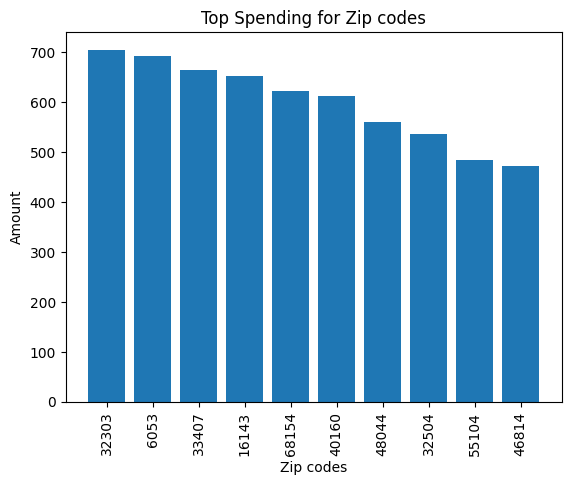

In [37]:
plt.bar(df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)[0:10].index.astype(str), df_merged.groupby(by=['zip'])['amt'].mean().sort_values(ascending=False)[0:10].values)
# Add labels and title
plt.xlabel('Zip codes')
plt.ylabel('Amount')
plt.title('Top Spending for Zip codes')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

plt.show()

# 7. Label Encoding

<p style="font-size:18px;">
   Label encoding is performed to convert categorical variables into numerical form, allowing machine learning algorithms to process them more effectively. 
</p>

In [38]:
label_encoder = LabelEncoder()

In [39]:
df_merged.category=label_encoder.fit_transform(df_merged.category)
df_merged.merchant=label_encoder.fit_transform(df_merged.merchant)
df_merged.gender=label_encoder.fit_transform(df_merged.gender)
df_merged.zip=label_encoder.fit_transform(df_merged.zip)
df_merged.job=label_encoder.fit_transform(df_merged.job)
df_merged['Age Group']=label_encoder.fit_transform(df_merged['Age Group'])

# 8. Feature Scaling

<p style="font-size:18px;">
   Feature scaling is performed to ensure that all features or variables in a dataset are on a comparable scale. Here we have used standardization to do feature scaling 
</p>

In [40]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_merged)

In [41]:
df_merged=pd.DataFrame(scaled_data,columns=df_merged.columns)

# 9. Anomaly Detection Model

## DBSCAN

<p style="font-size:18px;">
 DBSCAN is a density-based clustering algorithm that can also be used for anomaly detection. It groups together data points that are closely packed, and points that fall outside any cluster or have a low number of nearby points are considered anomalies.
</p>

In [42]:
dbscan = DBSCAN(eps=0.3, min_samples=5)


In [43]:
dbscan.fit(df_merged)


DBSCAN(eps=0.3)

In [44]:
# Extract the labels and the number of outliers
labels = dbscan.labels_
n_outliers = np.sum(labels == -1)
# Print the number of outliers
print(f"Number of outliers: {n_outliers}")
# Print the indices of the detected outliers
outlier_indices = np.where(labels == -1)[0]

Number of outliers: 129899


In [45]:
df_merged['Anomaly']=0

In [46]:
df_merged.loc[outlier_indices,'Anomaly']=1

<p style="font-size:18px;">
 The anomaly detection model has a detection rate of only 3%
</p>

In [47]:
df_merged.Anomaly.value_counts(1)

0    0.969514
1    0.030486
Name: Anomaly, dtype: float64

# 10. Model Evaluation

<p style="font-size:18px;">
 The presence of a fraud detection indicates the occurrence of abnormal spending, but the absence of a fraud detection does not necessarily imply normal spending. Therefore, we can utilize the "is_fraud" feature to assess the effectiveness of our abnormal spending model. By utilizing the "is_fraud" feature as an approximation of the actual value and considering abnormal spending as the predicted value, we can assess the model's performance by examining the recall score.
</p>

<p style="font-size:18px;">
 In the context of fraud detection, having a high recall is generally considered more important than having low precision. The model's ability to detect abnormal spending significantly reduces the occurrence of false negatives, ensuring that a significant proportion of genuine fraud cases are accurately identified.
</p>

<p style="font-size:18px;">
 Here it is evident that the anomaly detection model, which is designed to identify abnormal spending, can successfully detect 74% of fraudulent transactions. However, it is important to note that the overall detection rate of the model remains low at 3%.</p>

In [48]:
print(classification_report(list(fraud_label), list(df_merged.Anomaly)))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98   4255870
           1       0.03      0.74      0.06      5034

    accuracy                           0.97   4260904
   macro avg       0.51      0.86      0.52   4260904
weighted avg       1.00      0.97      0.98   4260904



In [49]:
df_merged.iloc[list(fraud_label[fraud_label==1].index),:].Anomaly.value_counts(1)

1    0.742948
0    0.257052
Name: Anomaly, dtype: float64

# 11. Feature Importance

<p style="font-size:18px;">
 Identifying the primary factors that contributed to detecting anomalies through the implementation of supervised learning
</p>

In [50]:
X=df_merged.drop(['Anomaly'],axis=1)

In [51]:
y=df_merged.Anomaly

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, list(y_train))

In [54]:
xgb_model = xgb.XGBClassifier()

In [55]:
xgb_model.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [56]:
y_pred = xgb_model.predict(X_test)


In [57]:
from sklearn.metrics import classification_report
print(classification_report(list(y_test), y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    826354
           1       0.71      0.97      0.82     25827

    accuracy                           0.99    852181
   macro avg       0.85      0.98      0.91    852181
weighted avg       0.99      0.99      0.99    852181



<p style="font-size:18px;">
The plot clearly indicates that the features "amt," "city_pop," "category," and "zip" are the most prominent indicators for identifying abnormal behaviors in relation to individuals' typical spending patterns.
</p>

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

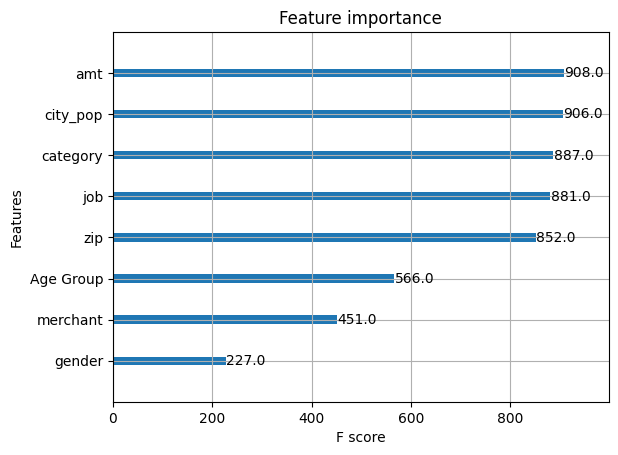

In [58]:
xgb.plot_importance(xgb_model)
